### Homework 1

In [3]:
# 导入需要的包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
# 设定随机数种子
np.random.seed(123)

##### 1. 读取 Minist 数据并预处理，划分训练集和验证集

In [10]:
def getMinistData(train_path, val_num):
    """
    对数据作归一化，并划分训练机、验证集和测试集
    """
    train = pd.read_csv(train_path, header=None)
    train = train.values
    np.random.shuffle(train)
    Xtrain, ytrain = train[val_num:, 1:] /255.0 * 0.99 + 0.01, train[val_num:, 0]
    Xval, yval = train[:val_num, 1:] /255.0 * 0.99 + 0.01, train[:val_num, 0]
    return Xtrain, ytrain, Xval, yval

# 得到训练集和验证集
trainPath = "./dataset/mnist_train.csv"
Xtrain, ytrain, Xval, yval = getMinistData(trainPath, val_num=10000)
print("Train set:", Xtrain.shape)
print("Val set:", Xval.shape)

Train set: (50000, 784)
Val set: (10000, 784)


* 预览训练集数据

true_label: [0 7 5 6 5]


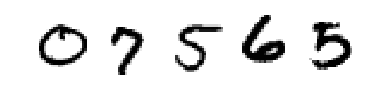

In [11]:
def plot_digit(data, filename):
    images=[instance.reshape(28, 28) for instance in data]
    image = np.concatenate(images,axis=1)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    plt.savefig(filename)

plot_digit(Xtrain[:5, :], 'Train_preview.png')
print("true_label:", ytrain[:5])

##### 2. 模型训练

* 定义模型类

In [1]:
class twoLayerNN:
    def __init__(self, input_size, hidden_size, output_size, std = 1e-3):
        """
        随机初始化参数
        """
        self.W1 = std * np.random.rand(input_size,hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = std * np.random.rand(hidden_size,output_size)
        self.b2 = np.zeros(output_size)
    
    def loadParams(self, path):
        """
        加载模型参数
        """
        try:
            paras = np.load(path)
            self.W1 = np.asarray(paras['W1'])
            self.W2 = np.asarray(paras['W2'])
            self.b1 = np.asarray(paras['b1'])
            self.b2 = np.asarray(paras['b2'])
        except:
            print("No models found. Please Train the network first.")
            exit()

    def computeLossandGrad(self, X, y, loss_only=False, reg=1e-3):
        """
        计算梯度和损失
        """
        N = X.shape[0]
        z1 = X.dot(self.W1) + self.b1
        a1 = np.maximum(z1, 0)
        z2 = z1.dot(self.W2) + self.b2
        expres = np.exp(z2)
        probs = expres / np.sum(expres, axis=1, keepdims=True)
        loss = -np.log(probs[range(N), y]).sum()/ N
        # 正则
        loss = loss + reg * (np.sum(self.W1 * self.W1) + np.sum(self.W2 * self.W2))
        # 如果只计算损失，则直接返回损失值
        if loss_only:
            return loss
            
        # Backward pass: compute gradients
        grads = {}
        dy = probs
        dy[range(N), y] -= 1
        dy /= N
        grads['W2'] = a1.T.dot(dy)+ reg * self.W2
        grads['b2'] = dy.sum(axis=0)
        da1 = dy.dot(self.W2.T)
        dz1 = np.where(z1 >= 0, da1, 0)
        grads['W1'] = X.T.dot(dz1) + reg * self.W1
        grads['b1'] = dz1.sum(axis=0)
        return loss, grads

    def train(self, X, y, Xval, yval, lr, learning_rate_decay, reg, epochs, batch_size):
        """
        训练模型
        """
        N = X.shape[0]
        iterations = int(np.floor(N / batch_size))
        train_loss_history = []
        val_loss_history = []
        train_acc_history = []
        val_acc_history = []

        for epoch in range(epochs):
            for iteration in range(iterations):
                # 随机采样
                batch_idxes = np.random.choice(N, batch_size)
                Xbatch = X[batch_idxes, :]
                ybatch = y[batch_idxes]
                # Compute loss and gradients using the current minibatch
                loss, grads = self.computeLossandGrad(Xbatch, y=ybatch, loss_only=False, reg=reg)
                # update the parameters
                self.W1 -= lr * grads['W1']
                self.b1 -= lr * grads['b1']
                self.W2 -= lr * grads['W2']
                self.b2 -= lr * grads['b2']
            # Check loss
            trainloss = self.computeLossandGrad(X, y=y, loss_only=True, reg=reg)
            valloss = self.computeLossandGrad(Xval, y=yval, loss_only=True, reg=reg)
            train_loss_history.append(trainloss)
            val_loss_history.append(valloss)
            # Check accuracy
            train_acc = self.evaluation(X, y)
            val_acc = self.evaluation(Xval, yval)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)
            print('Epoch %d / %d: train_loss %f \t val_loss %f \t train_acc %f \t val_acc %f, ' % (
                epoch, epochs, np.round(trainloss, 4), np.round(valloss, 4), 
                train_acc, val_acc))
            # Decay learning rate
            lr *= learning_rate_decay

        return {
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
            }

    def predict(self, X):
        """
        模型预测
        """
        scores = np.maximum(X.dot(self.W1) + self.b1, 0).dot(self.W2) + self.b2
        ypred = np.argmax(scores, axis=1)
        return ypred

    def evaluation(self, X, y):
        """
        模型评估：准确率
        """
        return (self.predict(X) == y).mean()

* 模型训练：

In [80]:
input_size = 28 * 28
hidden_size = 256
num_classes = 10
net = twoLayerNN(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(Xtrain, ytrain, Xval, yval, lr=0.01, learning_rate_decay=0.95, reg=1e-5, epochs=30, batch_size=64)

Epoch 0 / 30: train_loss 2.090300 	 val_loss 2.097300 	 train_acc 0.213380 	 val_acc 0.208300, 
Epoch 1 / 30: train_loss 1.520300 	 val_loss 1.524000 	 train_acc 0.546100 	 val_acc 0.540700, 
Epoch 2 / 30: train_loss 0.855400 	 val_loss 0.858800 	 train_acc 0.780700 	 val_acc 0.776300, 
Epoch 3 / 30: train_loss 0.596400 	 val_loss 0.600600 	 train_acc 0.842260 	 val_acc 0.836300, 
Epoch 4 / 30: train_loss 0.493600 	 val_loss 0.498400 	 train_acc 0.868400 	 val_acc 0.862800, 
Epoch 5 / 30: train_loss 0.440100 	 val_loss 0.445200 	 train_acc 0.882320 	 val_acc 0.876900, 
Epoch 6 / 30: train_loss 0.408200 	 val_loss 0.413100 	 train_acc 0.890640 	 val_acc 0.885000, 
Epoch 7 / 30: train_loss 0.388000 	 val_loss 0.393000 	 train_acc 0.895400 	 val_acc 0.889000, 
Epoch 8 / 30: train_loss 0.372700 	 val_loss 0.377800 	 train_acc 0.899100 	 val_acc 0.892400, 
Epoch 9 / 30: train_loss 0.361300 	 val_loss 0.366700 	 train_acc 0.903080 	 val_acc 0.897200, 
Epoch 10 / 30: train_loss 0.352300 	 val

##### 3. 可视化训练过程及隐层参数

* 训练集和验证集的损失和准确度曲线

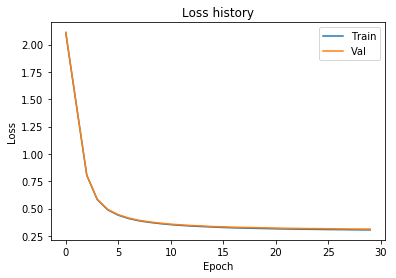

In [ ]:
plt.plot(stats['train_loss_history'])
plt.plot(stats['val_loss_history'])
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Train","Val"])
plt.savefig('loss.png')
plt.show()

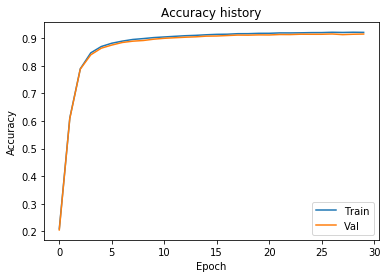

In [ ]:
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Train","Val"])
plt.savefig('accuracy.png')
plt.show()

* 可视化隐层的参数

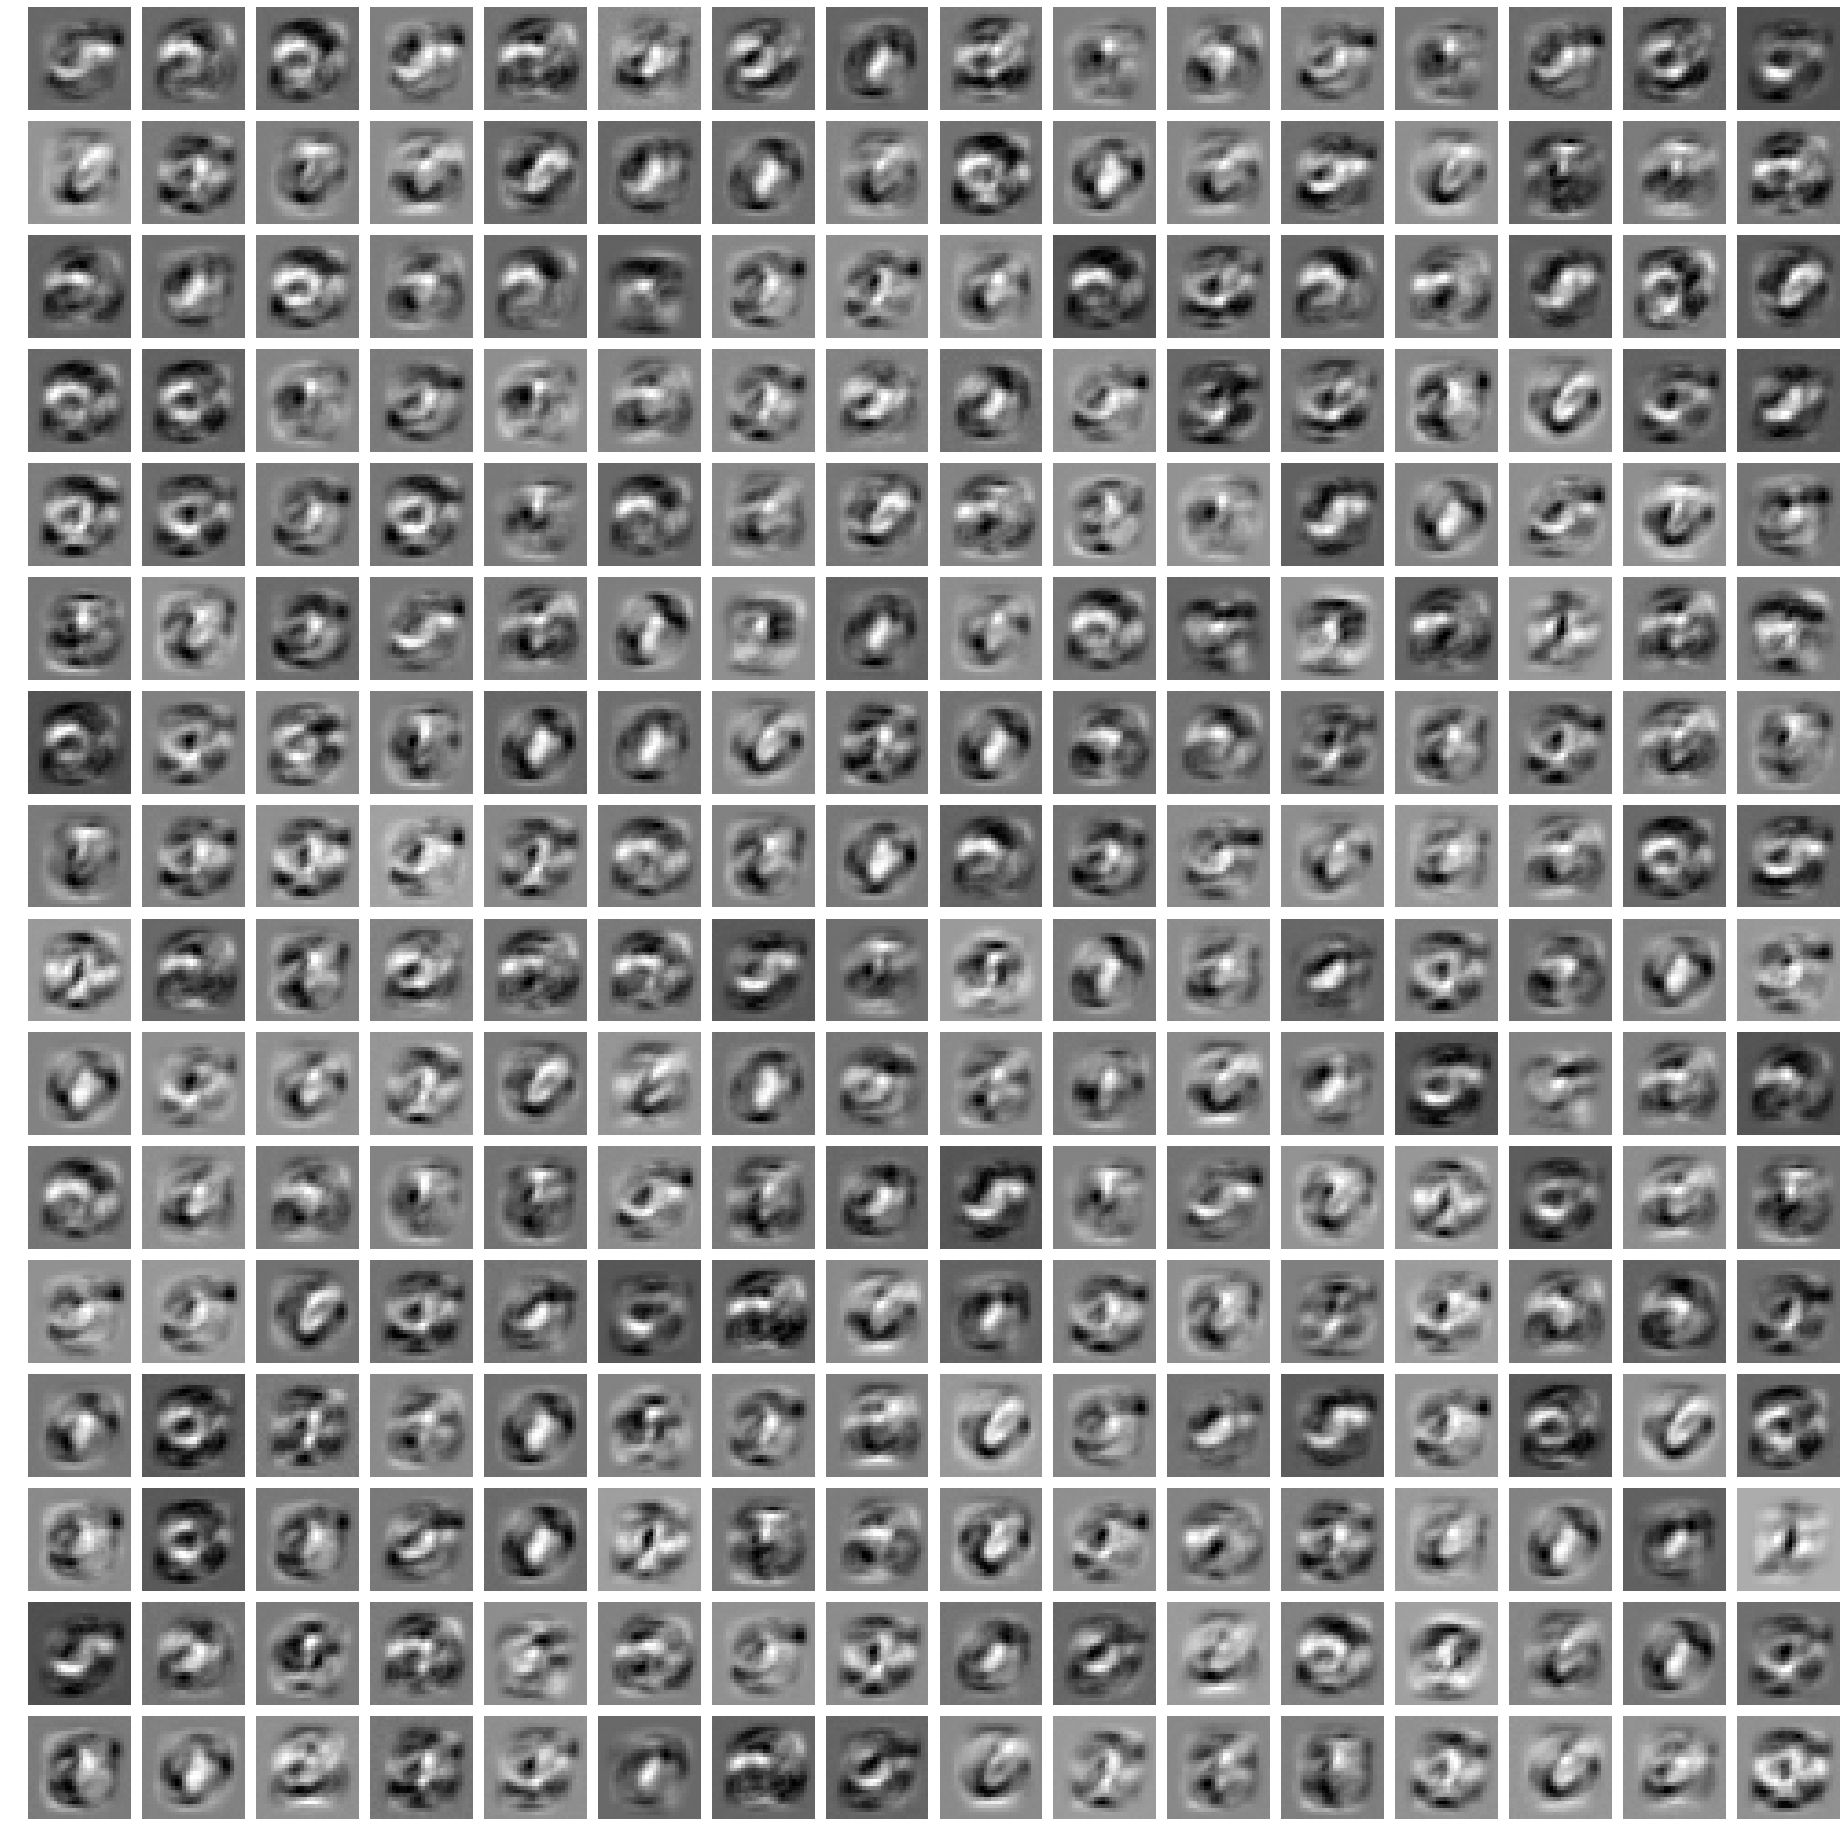

In [ ]:
W1 = net.W1
W1 = W1.reshape(28, 28, -1).transpose(2, 0, 1)
N, L = W1.shape[0], 28
grid_size = int(np.ceil(np.sqrt(N)))
padding = 3
grid_height = L * grid_size + padding * (grid_size - 1)
grid_width = L * grid_size + padding * (grid_size - 1)
grid = np.zeros((grid_height, grid_width))
next_idx = 0
y0, y1 = 0, L
for y in range(grid_size):
    x0, x1 = 0, L
    for x in range(grid_size):
        if next_idx < N:
            img = W1[next_idx]
            low, high = np.min(img), np.max(img)
            grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
        next_idx += 1
        x0 += L + padding
        x1 += L + padding
    y0 += L + padding
    y1 += L + padding
plt.figure(figsize=(40, 40), dpi=60)
plt.margins(0,0)
plt.imshow(grid, cmap = mpl.cm.binary)
plt.axis("off")
plt.savefig('netParas.png', bbox_inches='tight')

##### 4. 调参

* 隐层大小

In [ ]:
hidden_size_list = [64, 128, 256, 512]
stat_list = []
for hidden_size in hidden_size_list:
    print("hidden_size:", hidden_size)
    net = twoLayerNN(input_size, hidden_size, num_classes)
    stats = net.train(Xtrain, ytrain, Xval, yval, lr=0.01, learning_rate_decay=0.95, reg=1e-5, epochs=25, batch_size=64)
    stat_list.append(stats)

hidden_size: 64
Epoch 0 / 25: train_loss 2.147500 	 val_loss 2.154100 	 train_acc 0.206740 	 val_acc 0.202400, 
Epoch 1 / 25: train_loss 1.757800 	 val_loss 1.761100 	 train_acc 0.398860 	 val_acc 0.396100, 
Epoch 2 / 25: train_loss 1.074700 	 val_loss 1.079100 	 train_acc 0.739960 	 val_acc 0.734500, 
Epoch 3 / 25: train_loss 0.635000 	 val_loss 0.639800 	 train_acc 0.839000 	 val_acc 0.831900, 
Epoch 4 / 25: train_loss 0.498000 	 val_loss 0.503100 	 train_acc 0.868120 	 val_acc 0.863500, 
Epoch 5 / 25: train_loss 0.437600 	 val_loss 0.442800 	 train_acc 0.881820 	 val_acc 0.877500, 
Epoch 6 / 25: train_loss 0.403300 	 val_loss 0.408600 	 train_acc 0.890840 	 val_acc 0.885900, 
Epoch 7 / 25: train_loss 0.381200 	 val_loss 0.385900 	 train_acc 0.897280 	 val_acc 0.892200, 
Epoch 8 / 25: train_loss 0.364400 	 val_loss 0.369600 	 train_acc 0.902500 	 val_acc 0.895400, 
Epoch 9 / 25: train_loss 0.351800 	 val_loss 0.357800 	 train_acc 0.906340 	 val_acc 0.898500, 
Epoch 10 / 25: train_los

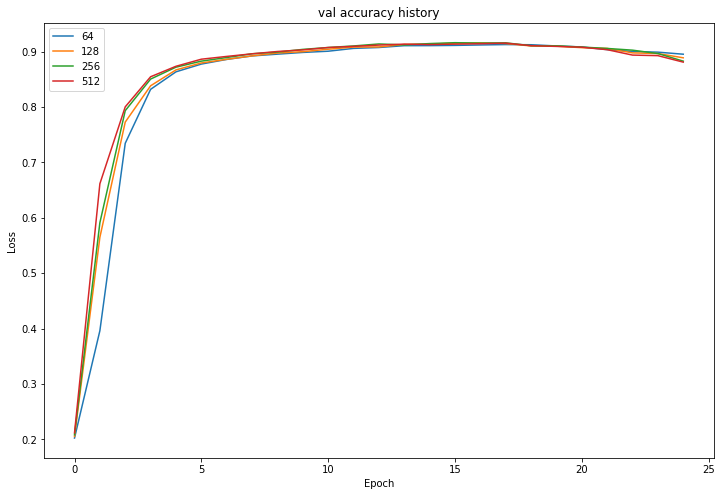

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(len(hidden_size_list)):
    plt.plot(stat_list[i]['val_acc_history'])
    plt.title('val accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.legend(hidden_size_list)
plt.savefig('para_hidden_size.png')
plt.show()

* 学习率

In [ ]:
hidden_size = 256
lr_list = [0.05, 0.01, 0.005, 0.001]
decay_list = [0.9, 0.95, 0.95, 0.99]
lr_stat_list = []
for i in range(len(lr_list)):
    lr, learning_rate_decay = lr_list[i], decay_list[i]
    print("lr:", lr, "decay:", learning_rate_decay)
    net = twoLayerNN(input_size, hidden_size, num_classes)
    stats = net.train(Xtrain, ytrain, Xval, yval, lr=lr, learning_rate_decay=learning_rate_decay, reg=1e-5, epochs=25, batch_size=64)
    lr_stat_list.append(stats)

lr: 0.05 decay: 0.9
Epoch 0 / 25: train_loss 0.469100 	 val_loss 0.472500 	 train_acc 0.875340 	 val_acc 0.870000, 
Epoch 1 / 25: train_loss 0.351000 	 val_loss 0.357500 	 train_acc 0.905440 	 val_acc 0.900800, 
Epoch 2 / 25: train_loss 0.318900 	 val_loss 0.327000 	 train_acc 0.919180 	 val_acc 0.911600, 
Epoch 3 / 25: train_loss 0.304200 	 val_loss 0.315400 	 train_acc 0.914300 	 val_acc 0.907700, 
Epoch 4 / 25: train_loss 0.298000 	 val_loss 0.308700 	 train_acc 0.895600 	 val_acc 0.890100, 
Epoch 5 / 25: train_loss 0.299000 	 val_loss 0.313200 	 train_acc 0.840160 	 val_acc 0.833800, 
Epoch 6 / 25: train_loss 0.301800 	 val_loss 0.314600 	 train_acc 0.792520 	 val_acc 0.789900, 
Epoch 7 / 25: train_loss 0.289200 	 val_loss 0.308500 	 train_acc 0.647620 	 val_acc 0.643100, 
Epoch 8 / 25: train_loss 0.287900 	 val_loss 0.306600 	 train_acc 0.489520 	 val_acc 0.486800, 
Epoch 9 / 25: train_loss 0.285500 	 val_loss 0.306900 	 train_acc 0.397080 	 val_acc 0.394000, 
Epoch 10 / 25: train

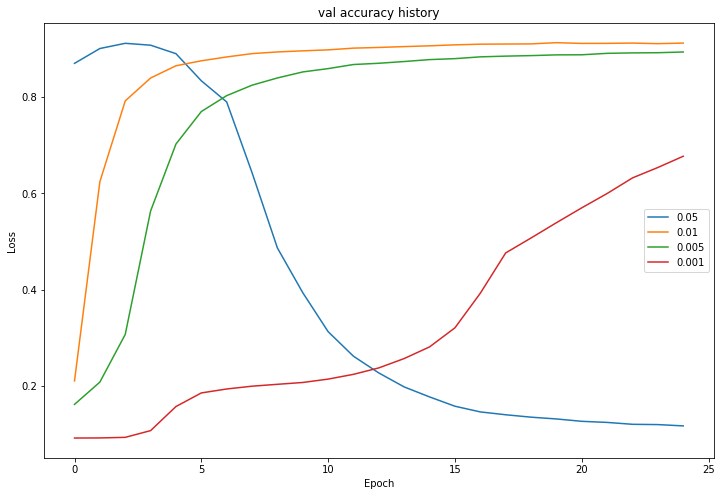

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(len(lr_list)):
    plt.plot(lr_stat_list[i]['val_acc_history'])
    plt.title('val accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.legend(lr_list)
plt.savefig('para_lr.png')
plt.show()

* 正则化强度

In [ ]:
hidden_size = 256
lr = 0.01
learning_rate_decay = 0.95
reg_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
reg_stat_list = []
for reg in reg_list:
    print("reg:", reg)
    net = twoLayerNN(input_size, hidden_size, num_classes)
    stats = net.train(Xtrain, ytrain, Xval, yval, lr=lr, learning_rate_decay=learning_rate_decay, reg=reg, epochs=25, batch_size=64)
    reg_stat_list.append(stats)

reg: 1e-05
Epoch 0 / 25: train_loss 2.096500 	 val_loss 2.103500 	 train_acc 0.212420 	 val_acc 0.207700, 
Epoch 1 / 25: train_loss 1.536100 	 val_loss 1.539300 	 train_acc 0.598340 	 val_acc 0.593900, 
Epoch 2 / 25: train_loss 0.876000 	 val_loss 0.879400 	 train_acc 0.789920 	 val_acc 0.787000, 
Epoch 3 / 25: train_loss 0.601800 	 val_loss 0.606400 	 train_acc 0.845620 	 val_acc 0.838500, 
Epoch 4 / 25: train_loss 0.495900 	 val_loss 0.501500 	 train_acc 0.869040 	 val_acc 0.862600, 
Epoch 5 / 25: train_loss 0.443000 	 val_loss 0.448000 	 train_acc 0.882700 	 val_acc 0.877600, 
Epoch 6 / 25: train_loss 0.411300 	 val_loss 0.416500 	 train_acc 0.889540 	 val_acc 0.883200, 
Epoch 7 / 25: train_loss 0.390200 	 val_loss 0.395700 	 train_acc 0.895800 	 val_acc 0.889500, 
Epoch 8 / 25: train_loss 0.375000 	 val_loss 0.380200 	 train_acc 0.899700 	 val_acc 0.893300, 
Epoch 9 / 25: train_loss 0.362800 	 val_loss 0.368900 	 train_acc 0.902820 	 val_acc 0.895000, 
Epoch 10 / 25: train_loss 0.3

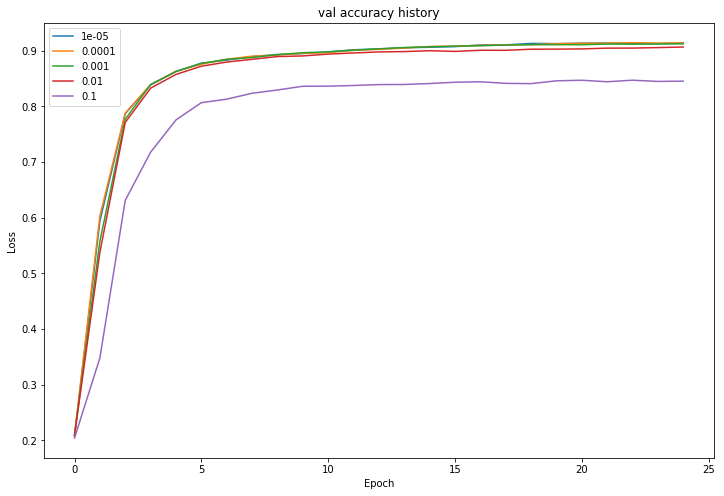

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(len(reg_list)):
    plt.plot(reg_stat_list[i]['val_acc_history'])
    plt.title('val accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.legend(reg_list)
plt.savefig('para_reg.png')
plt.show()

##### 5. 保存模型

In [ ]:
def save(model, filename):
    np.savez_compressed(
        file = os.path.join(os.curdir, filename),
        W1 = model.W1,
        W2 = model.W2,
        b1 = model.b1,
        b2 = model.b2
    )
filename='model.npz'   
save(net, filename)

##### 6. 加载模型和测试数据，进行预测

* 读取测试集数据并预处理

In [4]:
def loadTestset(test_path):
    test = pd.read_csv(test_path, header=None)
    test = test.values
    Xtest, ytest = test[:, 1:] /255.0 * 0.99 + 0.01, test[:, 0]
    return Xtest, ytest
testPath = "./dataset/mnist_test.csv"
Xtest, ytest = loadTestset(testPath)
print("Test set:", Xtest.shape)

Test set: (10000, 784)


* 初始化模型并加载参数

In [7]:
input_size = 28 * 28
hidden_size = 256
num_classes = 10
filename = 'model.npz'
predictModel = twoLayerNN(input_size, hidden_size, num_classes)
predictModel.loadParams(os.path.join(os.curdir, filename))

* 预测测试集

In [8]:
ypred = predictModel.predict(Xtest)
ypred

array([7, 2, 1, ..., 4, 5, 6])

* 可视化前 10 个数据及标签

True label: [7 2 1 0 4 1 4 9 6 9]


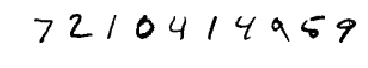

In [12]:
plot_digit(Xtest[:10, :], 'Test_preview.png')
print('True label:', ypred[:10])

* 评估模型在测试集准确率

In [13]:
test_acc = predictModel.evaluation(Xtest, ytest)
print("Test accuracy:", test_acc)

Test accuracy: 0.9204


* 混淆矩阵

In [14]:
def confusion_matrix(ytest, ypred):
    cm = np.zeros((10, 10), int)
    for i in range(len(ytest)):
        cm[ypred[i], ytest[i]] += 1
    return cm    
    
cfm = confusion_matrix(ytest, ypred)
pd.DataFrame(cfm)

,0,1,2,3,4,5,6,7,8,9
0,963,0,10,4,4,8,20,5,10,9
1,0,1117,1,1,3,2,3,7,15,6
2,4,5,967,32,11,8,5,32,18,3
3,1,2,9,902,0,29,1,2,30,10
4,0,0,8,0,884,2,6,3,9,22
5,6,2,4,41,3,806,21,1,52,11
6,4,3,8,2,13,11,900,0,14,0
7,1,2,11,15,5,4,1,959,16,36
8,1,4,12,10,1,15,1,1,798,4
9,0,0,2,3,58,7,0,18,12,908


* Precision

In [15]:
def precision(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return np.round(confusion_matrix[label, label] / row.sum(), 5)
    
precisions = [precision(i, cfm) for i in range(10)]
precisions


[0.93224,
 0.9671,
 0.89124,
 0.91481,
 0.94647,
 0.85111,
 0.94241,
 0.91333,
 0.94215,
 0.90079]

* Recall

In [16]:
def recall(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return np.round(confusion_matrix[label, label] / col.sum(), 5)
    
recalls = [recall(i, cfm) for i in range(10)]
recalls

[0.98265,
 0.98414,
 0.93702,
 0.89307,
 0.9002,
 0.90359,
 0.93946,
 0.93288,
 0.8193,
 0.8999]